In [1]:
%%capture
# 그래프에서 한글이 깨지지 않게 폰트 설치..
# *맨처음 실행 후 세션 다시 시작해야 반영됨!!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install gdown
!pip install einops
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
import torch
from torch import nn, optim
from kobert_tokenizer import KoBERTTokenizer
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange
import time
from torch.nn.utils.rnn import pad_sequence

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [5]:
# for random seed
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [6]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
pad_idx = tokenizer.pad_token_id
mask_idx = tokenizer.mask_token_id
sep_idx = tokenizer.sep_token_id
print("pad_idx = ", pad_idx)
print("mask_idx = ", mask_idx)
print("sep_idx = ", sep_idx)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


pad_idx =  1
mask_idx =  4
sep_idx =  3


## 하이퍼파라미터 조정

In [7]:
BATCH_SIZE = 128 # 논문에선 256
LAMBDA = 0 # 논문에선 0.01, l2-Regularization를 위한 hyperparam.
EPOCH = 15 # 논문에선 40
max_len = 100
criterion = nn.CrossEntropyLoss(ignore_index = -100) # -100 이 출력 나와야하는 시점의 loss는 무시 (마킹 안 한 시점 및 CLS,SEP,PAD 들어가는 시점)

### Linear Scheduler ###
warmup_steps = 1000 # 논문에선 10,000
LR_peak = 5e-4 # 논문에선 1e-4

new_model_train = False
hyuk_model_use = True # 여러분만의 모델 만들어서 사용하고 싶다면 False로

if hyuk_model_use:
    !gdown https://drive.google.com/uc?id=1BBsKceYT2MSXXoTTdBc3y37RyZFYJ4Sd -O BERT_base.pt
    !gdown https://drive.google.com/uc?id=14IBsA1OSDwCI0yOEV-DUYe4aeDL7KOHP -O BERT_base_history.pt
    save_model_path = 'BERT_base.pt'
    save_history_path = 'BERT_base_history.pt'
else:
    save_model_path = '/content/drive/MyDrive/Colab Notebooks/results/BERT_base2.pt'
    save_history_path = '/content/drive/MyDrive/Colab Notebooks/results/BERT_base2_history.pt'

Downloading...
From (original): https://drive.google.com/uc?id=1BBsKceYT2MSXXoTTdBc3y37RyZFYJ4Sd
From (redirected): https://drive.google.com/uc?id=1BBsKceYT2MSXXoTTdBc3y37RyZFYJ4Sd&confirm=t&uuid=1ea1897e-99bf-4e01-ae0b-39df2db7dab0
To: /content/BERT_base.pt
100% 1.17G/1.17G [00:12<00:00, 93.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=14IBsA1OSDwCI0yOEV-DUYe4aeDL7KOHP
To: /content/BERT_base_history.pt
100% 1.23k/1.23k [00:00<00:00, 5.46MB/s]


In [8]:
# BERT Large (3억 4천만 파라미터)
# n_layers = 24
# d_model = 1024
# d_ff = 4096 # d_model 의 네 배
# n_heads = 16
# drop_p = 0.1

# 실험에서 사용할 작은 BERT (drop_p 이외엔 BERT Base 와 일치)
n_layers = 12
d_model = 768
d_ff = d_model * 4
n_heads = 12
drop_p = 0.25 # BERT Base는 0.1 사용

In [9]:
print(tokenizer.get_vocab())
vocab_size = tokenizer.vocab_size
print(vocab_size)

print(tokenizer.tokenize("신발이 참 예쁘네요!"))
print(tokenizer.encode('신발이 참 예쁘네요!')) # string to index
print(tokenizer.decode([2155]))

{'[UNK]': 0, '[PAD]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '!': 5, "!'": 6, '!”': 7, '"': 8, '#': 9, '$': 10, '%': 11, '%)': 12, '&': 13, '&#34;': 14, "'": 15, "'(": 16, "',": 17, '(': 18, '(0': 19, '(1': 20, '(10': 21, '(12': 22, '(15': 23, '(17': 24, '(18': 25, '(19': 26, '(2': 27, '(20': 28, '(23': 29, '(24': 30, '(25': 31, '(3': 32, '(4': 33, '(5': 34, '(6': 35, '(7': 36, '(8': 37, '(9': 38, '(?)': 39, ')': 40, ")'": 41, '),': 42, ')’': 43, '*': 44, '+': 45, ',': 46, '-': 47, '----------------': 48, '-1': 49, '-2': 50, '-20': 51, '-3': 52, '-4': 53, '.': 54, '...': 55, '..."': 56, "...'": 57, '...”': 58, '/': 59, '0': 60, '0%': 61, '0%)': 62, '0.0': 63, '0.00': 64, '0.1': 65, '0.1%': 66, '0.2%': 67, '0.3': 68, '0.3%': 69, '0.4%': 70, '0.5': 71, '0.5%': 72, '0.6': 73, '0.6%': 74, '0.7': 75, '0.7%': 76, '0.8': 77, '0.8%': 78, '00': 79, '000.0': 80, '00000': 81, '01': 82, '02': 83, '02-': 84, '03': 85, '04': 86, '05': 87, '06': 88, '07': 89, '08': 90, '09': 91, '0:00:00': 92, '1': 

## DS, DL 생성 & 테스트

In [10]:
# data 다운
# %%capture
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126 에서 받을 수 있어요
!gdown https://drive.google.com/uc?id=14lAjaR2dRp5p5kEsm5GnwNM9KH-VgoOq -O 대화체.xlsx
data = pd.read_excel('대화체.xlsx')

Downloading...
From: https://drive.google.com/uc?id=14lAjaR2dRp5p5kEsm5GnwNM9KH-VgoOq
To: /content/대화체.xlsx
100% 9.57M/9.57M [00:00<00:00, 47.1MB/s]


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def mask_tokens(self, sentence):
        MARK_PROB = 0.15

        # 여기서는 패딩을 안하므로 문장마다 길이가 다름! collate_fn 에서 padding을 가장 긴 문장에 맞춰서 해줄 필요가 있음
        input_ids = tokenizer.encode(sentence, truncation=True, max_length = max_len, add_special_tokens=False)

        segment_ids = [] # segment embedding을 위해
        labels = []
        is_second_sentence = False  # 현재 토큰이 두 번째 문장에 있는지 여부
        for i, token in enumerate(input_ids):
            val = random.random()
            if val <= MARK_PROB and token not in {tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id}:
                # 전체 토큰 중 15%를 마스킹 대상으로 선택 + CLS, SEP, PAD는 마스킹하지 않음
                labels.append(token) # 일단 마킹이 됐으면 세 경우 중 어떤 경우라도 원래 자기자신 튀어나게끔 학습한다
                val = random.random() # 다시 난수 생성
                if val < 0.8: # 80% 확률로 [MASK] 토큰으로 교체
                    input_ids[i] = mask_idx
                elif 0.8 <= val < 0.9: # 10% 확률로 랜덤 토큰으로 교체
                    input_ids[i] = random.choice(list(tokenizer.get_vocab().values()))
                # 나머지 10%는 원래의 토큰을 유지
            else:
                labels.append(-100)

            segment_ids.append(0 if not is_second_sentence else 1)  # Segment 인덱스 설정
            if token == sep_idx:
                is_second_sentence = True  # 처음 [SEP] 토큰을 만날 때 True로

        return torch.tensor(input_ids), torch.tensor(labels), torch.tensor(segment_ids)

    def __getitem__(self, idx):
        # 첫 번째 문장 선택
        sentence1 = self.data.loc[idx, '원문']

        # 랜덤한 두 번째 문장 선택
        random_idx = random.randint(0, len(self.data) - 1)
        sentence2 = self.data.loc[random_idx, '원문']

        # [CLS] sentence1 [SEP] sentence2 [SEP] 형태로 결합
        combined_sentence = '[CLS]' +  sentence1 +  '[SEP]' + sentence2 + '[SEP]'

        # NSP 레이블은 항상 0으로 설정 (우리 데이터셋의 문장들은 이어지는 문장은 아니라서)
        nsp_label = torch.tensor(0)

        input_ids, mtp_label, segment_ids = self.mask_tokens(combined_sentence)

        return input_ids, mtp_label, nsp_label, segment_ids

def custom_collate_fn(batch):
    # batch 는 리스트이고 (input_ids, mtp_label, nsp_label, segment_ids)와 같이 튜플로 128 개가 들어가 있음
    # collate_fn 의 역할은 Batch 데이터를 하나의 텐서로 만드는 것. 최종적으로 (배치텐서, 배치텐서, 배치텐서, 배치텐서) 이렇게 튜플로 return
    # 따라서, 128개의 input_ids 끼리, 128개의 mtp_label 끼리, 128개의 nsp_label 끼리, 128개의 segment_ids 끼리 길이가 같아야 함
    # 그런데 default_collate_fn 은 길이가 다른 것을 맞춰주진 않음. 그래서 이 custom_collate_fn을 만들어 줘야!

    # batch 내의 각 항목을 분리
    input_ids = [item[0] for item in batch]
    mtp_labels = [item[1] for item in batch]
    nsp_labels = [item[2] for item in batch]
    segment_ids = [item[3] for item in batch]

    # padding 처리를 하여 모든 시퀀스를 같은 길이로 맞춰 하나의 행렬을 만듦 (가장 긴 문장에 맞춰줌!)
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    mtp_labels = pad_sequence(mtp_labels, batch_first=True, padding_value=-100)
    segment_ids = pad_sequence(segment_ids, batch_first=True, padding_value=1)

    # torch.stack을 사용하여 nsp_labels를 배치로 결합 (nsp_labels은 어차피 숫자 한 개라서 pad_sequence 안 해도 됨)
    nsp_labels = torch.stack(nsp_labels)

    return input_ids, mtp_labels, nsp_labels, segment_ids

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


In [12]:
# pad_sequence 실험
seq1 = torch.tensor([2, 2, 3])
seq2 = torch.tensor([4, 5])
seq3 = torch.tensor([6, 7, 8, 9])
sequences = [seq1, seq2, seq3]

padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=tokenizer.pad_token_id)
print(padded_sequences)

tensor([[2, 2, 3, 1],
        [4, 5, 1, 1],
        [6, 7, 8, 9]])


In [16]:
# train_DL 테스트
for x_batch, mtp_label, nsp_label, segment_ids in train_DL:

    print(x_batch.shape)
    print(mtp_label.shape)
    print(nsp_label.shape)
    print(segment_ids.shape)
    print(x_batch[0])
    print(mtp_label[0])
    print(nsp_label[0])
    print(segment_ids[0])

    print(tokenizer.decode(x_batch[0]))

    break

torch.Size([128, 69])
torch.Size([128, 69])
torch.Size([128])
torch.Size([128, 69])
tensor([   2, 2707,    4, 7782, 6705,    4, 2959, 7354, 7088, 3824, 6855, 6369,
         862, 3220,    4, 6738, 5591, 6999,  258,    3,  736, 1706, 3252, 3135,
         889, 6122, 5771, 1456, 5872,    4, 1100, 7088,  862, 6844,   54,    3,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1])
tensor([-100, -100, 2405, -100, -100, 6198, -100, -100, -100, -100, -100, -100,
        -100, -100, 5969, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, 5859, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -10

## 모델 구현

In [17]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(drop_p) # GPT-1 에선 어텐션 드롭아웃 적용, BERT는 언급은 안되어 있음
        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, x, mask=None):
        Q = self.fc_q(x)  # 개단차
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤 = self.n_heads)

        attention_score = Q @ K.transpose(-2,-1) / self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10
        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention_weights = self.dropout(attention_weights) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(x)  # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten_LN = nn.LayerNorm(d_model)
        self.self_atten = MHA(d_model, n_heads, drop_p)

        self.FF_LN = nn.LayerNorm(d_model)
        self.FF = FeedForward(d_model, d_ff, drop_p)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual = self.self_atten_LN(x)
        residual, atten_enc = self.self_atten(residual, enc_mask)
        residual = self.dropout(residual) # 원랜 attn -> drop -> add -> norm 이었는데 norm -> attn -> drop -> add 순으로 변경 (GPT-2 에서)
        x = x + residual                  # BERT도 그냥 이렇게 반영해줌 (https://github.com/codertimo/BERT-pytorch/blob/master/bert_pytorch/model/utils/sublayer.py 참고)

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        x = x + residual

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.seg_embedding = nn.Embedding(2, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.LN_out = nn.LayerNorm(d_model)

    def forward(self, x, seg, enc_mask, atten_map_save = False): # x.shape = 개단, enc_out.shape = 개단차, enc_mask.shape = 개헤단단

        pos = torch.arange(x.shape[1]).expand_as(x).to(DEVICE) # 개단

        x = self.token_embedding(x) + self.pos_embedding(pos) + self.seg_embedding(seg) # 개단차
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, enc_mask)
            if atten_map_save is True:
                atten_encs = torch.cat([atten_encs , atten_enc[0].unsqueeze(0)], dim=0) # 층헤단단 ㅋ

        x = self.LN_out(x) # pre-acrivation 이기 때문에 fc_out 전에 (CNN 에서는 GAP-fc => BN-relu-GAP-fc 로 추가했었음)
        # 그리고, activation 없이 바로 fc_out 통과시키더라 (https://github.com/graykode/gpt-2-Pytorch/blob/master/GPT2/model.py#L205 참고)

        return x, atten_encs

class BERT(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.encoder = Encoder(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        # 초기화 기법은 GPT-2 참고해서 만듦
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.02) # GPT-1 논문에서의 초기화
                m.weight.data *= 1/torch.sqrt(torch.tensor(n_layers*2)) # 이건 GPT-2 논문에서 변형한 초기화 (residual 에 1/sqrt(N) 곱하기, N:residual 총 개수)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.02) # 임베딩 레이어는 residual이 아니라서 이것만

    def make_enc_mask(self, x): # x.shape = 개단

        enc_mask = (x == pad_idx).unsqueeze(1).unsqueeze(2) # 개11단
        enc_mask = enc_mask.expand(x.shape[0], self.n_heads, x.shape[1], x.shape[1]) # 개헤단단
        """ pad mask (문장 마다 다르게 생김. 이건 한 문장에 대한 pad 행렬)
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_mask

    def forward(self, x, seg, atten_map_save = False):

        enc_mask = self.make_enc_mask(x)

        out, atten_encs = self.encoder(x, seg, enc_mask, atten_map_save = atten_map_save)

        return out, atten_encs

class BERTLM(nn.Module): # BERT Language Model <- pre-training 때 사용할 헤드라고 생각하면 됨, fine-tuning 때는 task에 맞게 다른 head를 사용
    def __init__(self, bert, vocab_size, d_model):
        super().__init__()

        self.bert = bert

        self.nsp = nn.Linear(d_model, 2) # NSP: Next Sentence Prediction
        self.mtp = nn.Linear(d_model, vocab_size) # MTP: Masked Token Prediction

        nn.init.normal_(self.nsp.weight, mean=0, std=0.02) # 얘는 residual이 아니기 때문에 원래 초기화대로
        nn.init.normal_(self.mtp.weight, mean=0, std=0.02)

    def forward(self, x, seg, atten_map_save = False):

        x, atten_encs = self.bert(x, seg, atten_map_save)

        return self.nsp(x[:,0]), self.mtp(x), atten_encs

## 모델 생성

In [18]:
bert = BERT(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)
model = BERTLM(bert, vocab_size, d_model).to(DEVICE)

x = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)
seg = torch.tensor([[0,0,0,0,1,1,1],[0,0,0,0,1,1,1]]).to(DEVICE)
print(x.shape)

model.eval()
with torch.no_grad():
    nsp_out, mtp_out, _ = model(x, seg)
print(nsp_out.shape)
print(mtp_out.shape)

torch.Size([2, 7])
torch.Size([2, 2])
torch.Size([2, 7, 8002])


## Train, Test, loss_epoch 함수

In [19]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        epoch_start = time.time()

        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}   time: {time.time()-epoch_start:.0f} s")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for x_batch, mtp_label, nsp_label, segment_ids in tqdm(DL, leave=False):
        x_batch = x_batch.to(DEVICE)
        mtp_label = mtp_label.to(DEVICE)
        nsp_label = nsp_label.to(DEVICE)
        segment_ids = segment_ids.to(DEVICE)
        # inference
        y_hat_NSP = model(x_batch, segment_ids)[0]
        y_hat_MTP = model(x_batch, segment_ids)[1]
        # NSP와 MTP 각각에 대한 손실 계산
        nsp_loss = criterion(y_hat_NSP, nsp_label)
        mtp_loss = criterion(y_hat_MTP.permute(0,2,1), mtp_label) # y_hat은 개차단이 되어야
        loss = nsp_loss + mtp_loss
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        rloss += loss.item() * x_batch.shape[0]
    loss_e = rloss/N
    return loss_e

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

class LinearWarmupLinearDecayScheduler:
    def __init__(self, optimizer, warmup_steps, total_steps, max_lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.max_lr = max_lr
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lrate = self.max_lr * (self.current_step / self.warmup_steps)
        else:
            decay_steps = self.total_steps - self.warmup_steps
            lrate = self.max_lr * max(0, float(decay_steps - (self.current_step - self.warmup_steps)) / decay_steps)
        self.optimizer.param_groups[0]['lr'] = lrate

def plot_scheduler(optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps:
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    plt.plot(steps, lr_history, 'b', linewidth=2, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

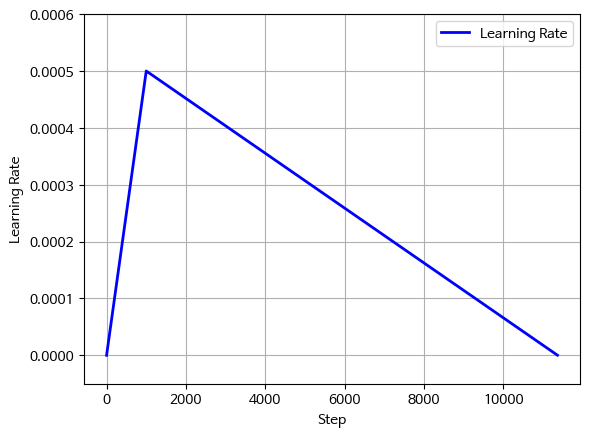

In [ ]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = LinearWarmupLinearDecayScheduler(optimizer, warmup_steps=warmup_steps, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE), max_lr=LR_peak)
plot_scheduler(optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

## 모델 학습

In [ ]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우를 대비
    optimizer = optim.AdamW(params, lr=LR_peak, weight_decay=LAMBDA, betas=(0.9,0.999)) # BERT에선 Adam 사용
    scheduler = LinearWarmupLinearDecayScheduler(optimizer, warmup_steps=warmup_steps, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE), max_lr=LR_peak)

    Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

## 로드 모델

In [26]:
loaded = torch.load(save_model_path, map_location=DEVICE, weights_only=False)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

14
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0
    maximize: False
    weight_decay: 0
)


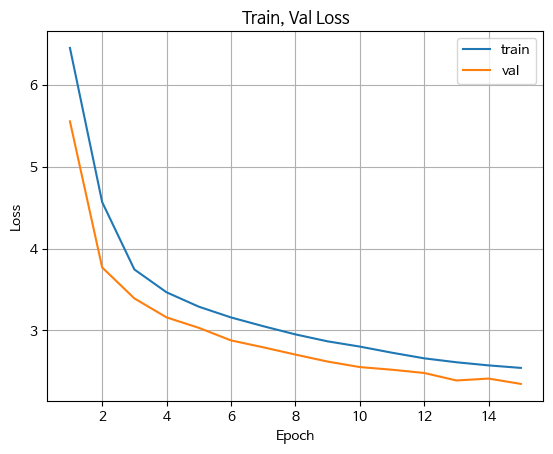

In [ ]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

In [ ]:
Test(load_model, test_DL, criterion) # seed 고정을 안해놔서 test에 train data가 섞임
count_params(load_model)

Test loss: 2.270 | Test PPL: 9.683


97434948

## 빈칸 채우는 함수, 어텐션 map 그리는 함수

In [43]:
def restore_masked_sentence(model, dataset, sentence_index):
    # 특정 문장 선택
    sentence = '[CLS]' + dataset.dataset.data.loc[sentence_index, '원문'] + '[SEP]'

    # 문장을 마스킹 처리
    input_ids, labels, seg = dataset.dataset.mask_tokens(sentence)
    masked_sentence = tokenizer.decode(input_ids)

    # 모델을 평가 모드로 설정 및 출력 예측
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.unsqueeze(0).to(DEVICE) # 모델에 전달하기 위해 배치 차원 추가 및 DEVICE로
        labels = labels.to(DEVICE)
        seg = seg.to(DEVICE)
        _, outputs, atten_encs = model(input_ids, seg, atten_map_save = True)
        predictions = outputs.argmax(dim=2)  # 가장 확률이 높은 토큰의 인덱스 선택

    # 원래 문장에서 label 이 -100이 아닌 시점의 토큰들만 바꿀 거니까 -100인 애들은 input_ids 과 같게
    predictions[0, labels == -100] = input_ids[0, labels == -100]
    # 토큰 인덱스를 텍스트로 디코딩하여 복원된 문장 생성
    restored_sentence = tokenizer.decode(predictions[0])

    return sentence, masked_sentence, restored_sentence, atten_encs

def show_attention(atten, Query, Key, n):
    atten = atten.cpu()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[atten.shape[3]*1.5,atten.shape[2]])
    for i in range(3):
        ax[i].set_yticks(range(atten.shape[2]))
        ax[i].set_yticklabels(Query, rotation=45)
        ax[i].set_xticks(range(atten.shape[3]))
        ax[i].set_xticklabels(Key, rotation=60)
        ax[i].imshow(atten[n-1][i], cmap='bone') # n 번째 layer, 앞 세 개의 헤드만 plot
        # ax[i].xaxis.tick_top()  # x축 레이블을 위쪽으로 이동

In [48]:
sentence, masked_sentence, restored_sentence, atten_encs = restore_masked_sentence(load_model, test_DS, 1)

print(f"입력: {sentence}")
print(f"마스킹된 문장: {masked_sentence}")
print(f"BERT 출력: {restored_sentence}")

입력: [CLS]판매량이 지난번 제품보다 빠르게 늘고 있습니다.[SEP]
마스킹된 문장: [CLS]판매량이 지난번 제품보다 빠르게 늘고 있습니다.[SEP]
BERT 출력: [CLS]판매량이 지난번 제품보다 빠르게 늘고 있습니다.[SEP]


13
torch.Size([12, 12, 13, 13])


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


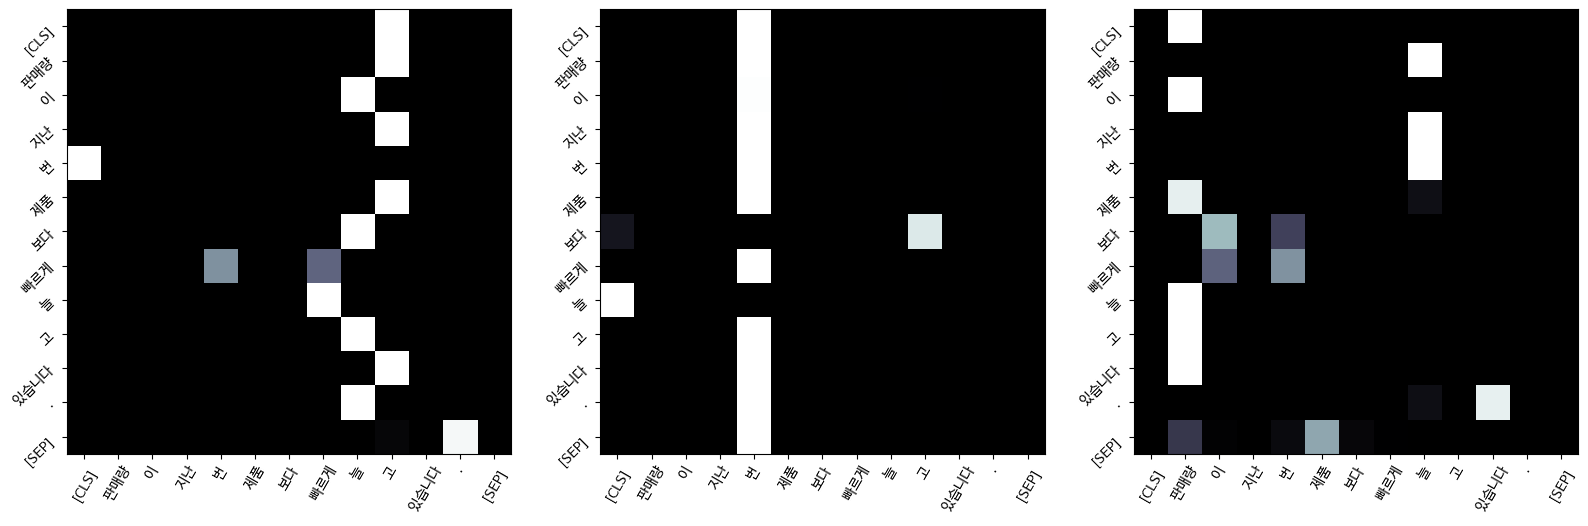

In [56]:
enc_tokens = tokenizer.tokenize(restored_sentence)
sep_position = enc_tokens.index('[SEP]') # 뒷 부분이 [PAD]로 가득 차 있어서 [SEP] 까지만 보고자 함

enc_tokens_trunc = enc_tokens[:sep_position+1]
atten_encs_trunc = atten_encs[:,:,:sep_position+1, :sep_position+1]

print(len(enc_tokens_trunc))
print(atten_encs_trunc.shape)
show_attention(atten_encs_trunc, enc_tokens_trunc, enc_tokens_trunc, n = 12)
# 그래프 해석하는 방법: 어떤 단어를 보고 이 단어로 채웠을까?
# future mask 없으니 전체를 보고 임베딩 하는 것을 볼 수 있음

# 첫 레이어에서는 직전 토큰 혹은 바로 다음 토큰을 보고 임베딩하려는 모습